#Exploratory Data Analysis of the Beth Cyber Security Dataset

In [1]:
# import Statements

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt # viz
import seaborn as sns # viz
import sklearn
from scipy import stats



import warnings
warnings.filterwarnings('ignore')

In [2]:
path ='/content/gdrive'
from google.colab import drive
drive.mount(path)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/BethData'

/content/gdrive/MyDrive/BethData


# Loading in the Data

In [4]:
train = pd.read_csv("labelled_training_data.csv", engine = "python",on_bad_lines='skip')
test = pd.read_csv("labelled_testing_data.csv" ,engine = 'python',on_bad_lines='skip')

In [5]:
train.dtypes

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object

# Checking for Null values in the Raw Dataset

No null values were found

In [6]:
datasets = [train, test]
dataset_names = ['Train', 'Test']
for dataset, name in zip(datasets,dataset_names):
    print(f'Nulls in {name} Dataset')
    print(dataset.isnull().sum())
    print(' ')

Nulls in Train Dataset
timestamp          0
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
processName        0
hostName           0
eventId            0
eventName          0
stackAddresses     0
argsNum            0
returnValue        0
args               0
sus                0
evil               0
dtype: int64
 
Nulls in Test Dataset
timestamp          0
processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
processName        0
hostName           0
eventId            0
eventName          0
stackAddresses     0
argsNum            0
returnValue        0
args               0
sus                0
evil               0
dtype: int64
 


# Finding the Number of Unique Values in the raw dataset

If the number of unique values exceeded 12, instead of printing at the list of unique values, only the count was printed. Notably, there were more IP addresses seen in the training dataset while only one was seen in the testing dataset. There also were more unique processID's, threadID's and higher timestamps seen in the training set than the testing set. We saw an additional user (user 1001) in the testing set that was not in the training set.

In [7]:
datasets = [train, test]
dataset_names = ['Train', 'Test']

for dataset, name in zip(datasets,dataset_names):
  print(' ')
  print(f'Unique Values of {name} Dataset')
  for column in dataset:
      unique_vals = np.unique(dataset[column])
      num_of_values = len(unique_vals)
      if num_of_values < 12:
          print('The number of values for feature {} :{} -- {}'.format(column, num_of_values,unique_vals))
      else:
          print('The number of values for feature {} :{}'.format(column, num_of_values))

 
Unique Values of Train Dataset
The number of values for feature timestamp :762911
The number of values for feature processId :545
The number of values for feature threadId :588
The number of values for feature parentProcessId :205
The number of values for feature userId :7 -- [   0  100  101  102  103  109 1000]
The number of values for feature mountNamespace :6 -- [4026531840 4026532217 4026532229 4026532231 4026532232 4026532288]
The number of values for feature processName :36
The number of values for feature hostName :8 -- ['ip-10-100-1-120' 'ip-10-100-1-173' 'ip-10-100-1-28' 'ip-10-100-1-34'
 'ip-10-100-1-55' 'ip-10-100-1-57' 'ip-10-100-1-79' 'ubuntu']
The number of values for feature eventId :32
The number of values for feature eventName :32
The number of values for feature stackAddresses :97050
The number of values for feature argsNum :6 -- [0 1 2 3 4 5]
The number of values for feature returnValue :524
The number of values for feature args :214720
The number of values for fea

# Finding the frequency of the target variable in the training and test split of the dataset

There were only 1269 sus values in the dataset out of about 760000 total values. Conversely, there were 171459 sus values out of about 190000 total values in the testing dataset. This is because the training dataset is meant to act as a baseline model from which to train an unsupervised anomaly detection model while the testing set is meant to asses this models predictive ability. In a real anomoly detection problem, we would likely not have access to a testing set with labels, so this dataset is a very useful tool in testing the ability of various Anomaly Detection algorithms on a dataset built from computer activity.

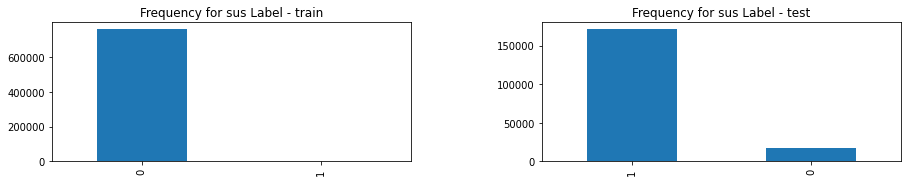

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
fig.tight_layout(pad=10.0)

datasets = [train, test]
dataset_names = ['train', 'test']
axs = [ax1, ax2]

for dataset, name, ax in zip(datasets, dataset_names, axs):
    dataset.sus.value_counts().plot(kind='bar', title=f'Frequency for sus Label - {name}',ax = ax)

In [9]:
np.unique(train['sus'], return_counts=True)

(array([0, 1]), array([761875,   1269]))

In [10]:
np.unique(test['sus'], return_counts=True)

(array([0, 1]), array([ 17508, 171459]))

# Finding Correlations between the variable

In the training set, the UserID seems to be strongly correlated to the sus value as seen by a correlation of 0.86. ThreadID and ProcessID have a correlation of 1, so one of these columns should be removed when training the model. In the testing dataset, we saw relatively strong correlations of the timestamp, parentProcessID and the UserID (0.62, 0.69, 0.77 respectively) to the sus value. This suggests that they may have some linear predictive relationship that could be exploited for detection purposes.

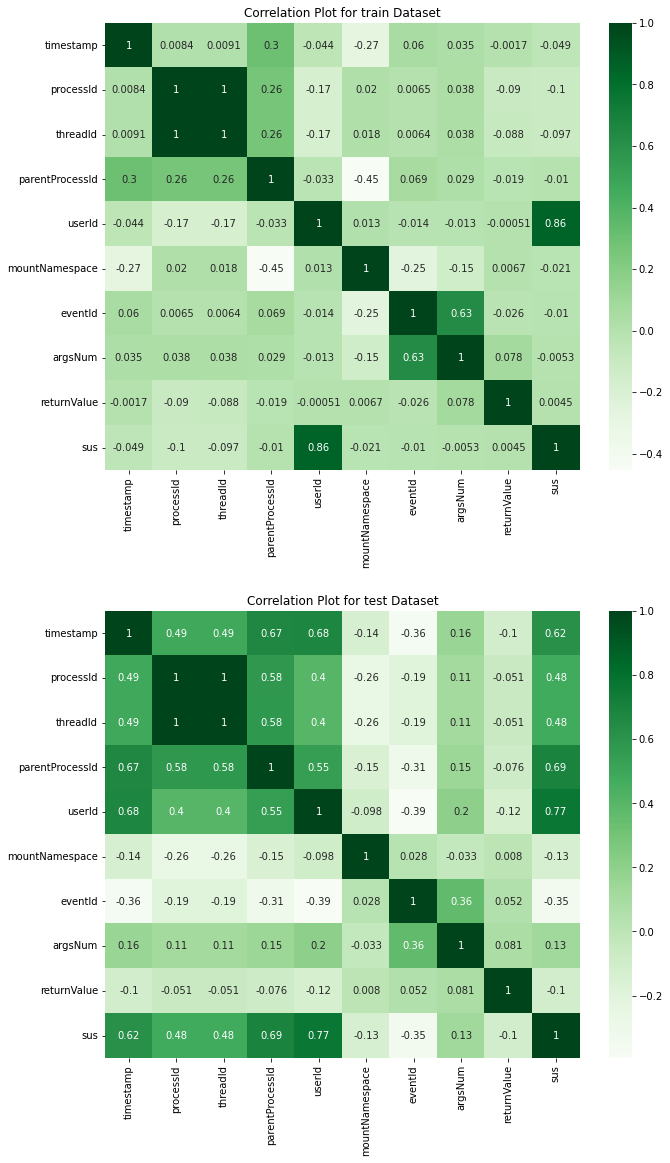

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,18))
fig.tight_layout(pad=12.0)

datasets = [train.loc[:,train.columns != 'evil'], test.loc[:, test.columns != 'evil']]
dataset_names = ['train', 'test']
axs = [ax1, ax2]

for dataset, name, ax in zip(datasets, dataset_names, axs):
    corr = dataset.corr()
    sns.heatmap(corr, ax = ax, annot=True, cmap="Greens")
    ax.set_title(f'Correlation Plot for {name} Dataset')

# Processing

There are a number of columns that won't be too useful in model training. The threadID was dropped it is highly correlated to another feature. We dropped timestamp because it had some correlations to a number of features. The hostnames feature was dropped because IP are not beneficial in categorizing behavior unless they have a history of malicious activity. It is very easy for an attacker to choose a new IP address at any given time, though they are useful for finding other related threat activity when doing an investigation. The args column has great information, but it has a very complex data structure, made up of a dictionary with varying numbers of key value pairs. It will take in depth feature engineering to extract the valuable information so we will focus on other columns for the time being.

In the end, the columns to be kept are ProcessID, parentProcessID, UserID, mountNameSpace, eventID, argsNum, and returnValue. There are many ways to extract useful information from these features, but one way is to map values to Operating System and Kernel events. In linux, processID's of 0, 1, and 2 as well as UserID's of less than 1000 or used only for Kernel/System processes. This can be useful information because most malicious activity begins at the OS level. Additionally, MountNamespace can be mapped to a binary event of whether the value is 4026531840 or not. This mount namespace indicates the /mnt directory which is where all manually mounted points are linked and is also the mounting point for all OS users unless otherwise specified. The returnValue feature tells us whether a function value completed sucessfully or not, and can be mapped to succes, success with a signal to the parent process, and an error. This feature engineering should be sufficent enough to train a moderately successful anomaly detection model.


In [12]:
class Data_Process:

    def __init__(self, split='train'):
            if split == 'train':
                data = train
            elif split == 'test':
                data = test
            else:
                raise Exception("Error: Invalid 'split' given")
            self.name = split
            # Select columns and perform pre-processing
            labels = pd.DataFrame(data[["sus"]])
            data = pd.DataFrame(data[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]])
            data["processId"] = data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
            data["parentProcessId"] = data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
            data["userId"] = data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS (1)/not OS
            data["mountNamespace"] = data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
            data["eventId"] = data["eventId"]  # Keep eventId values (requires knowing max value)
            data["returnValue"] = data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success (0)/success with value(1)/error(2)
            self.data = data
            self.labels = labels

In [13]:
training = Data_Process()
testing = Data_Process(split = 'test')

In [14]:
trainingPlot = pd.concat([training.data, training.labels], axis=1)
testingPlot = pd.concat([testing.data, testing.labels], axis=1)

In [15]:
np.unique(testing.labels, return_counts = True)

(array([0, 1]), array([ 17508, 171459]))

In [16]:
datasets = [training.data,testing.data]
dataset_names = ['Train','Test']

for dataset, name in zip(datasets,dataset_names):
  print(' ')
  print(f'Unique Values of {name} Dataset')
  for column in dataset:
      unique_vals = np.unique(dataset[column])
      num_of_values = len(unique_vals)
      if num_of_values < 12:
          print('The number of values for feature {} :{} -- {}'.format(column, num_of_values,unique_vals))
      else:
          print('The number of values for feature {} :{}'.format(column, num_of_values))

 
Unique Values of Train Dataset
The number of values for feature processId :2 -- [0 1]
The number of values for feature parentProcessId :2 -- [0 1]
The number of values for feature userId :2 -- [0 1]
The number of values for feature mountNamespace :2 -- [0 1]
The number of values for feature eventId :32
The number of values for feature argsNum :6 -- [0 1 2 3 4 5]
The number of values for feature returnValue :3 -- [0 1 2]
 
Unique Values of Test Dataset
The number of values for feature processId :2 -- [0 1]
The number of values for feature parentProcessId :2 -- [0 1]
The number of values for feature userId :2 -- [0 1]
The number of values for feature mountNamespace :2 -- [0 1]
The number of values for feature eventId :46
The number of values for feature argsNum :6 -- [0 1 2 3 4 5]
The number of values for feature returnValue :3 -- [0 1 2]


#CountPlot grouped by Target
By creating a count plot for each feature grouped by the target variable, we can gain a few key insights. Process, Parent Process ID, and mount name space do not appear have a clear relationship to the target class when comparing their distributions in the training and testing datasets. UserID shows a clear relationship with the anomaly class when the value is 1. An ArgsNum value of 3 appears to be a clear indicator of an anomaly. Also, a return value of 2 (which means an error was thrown) also shows a clear relationship with the anomaly class

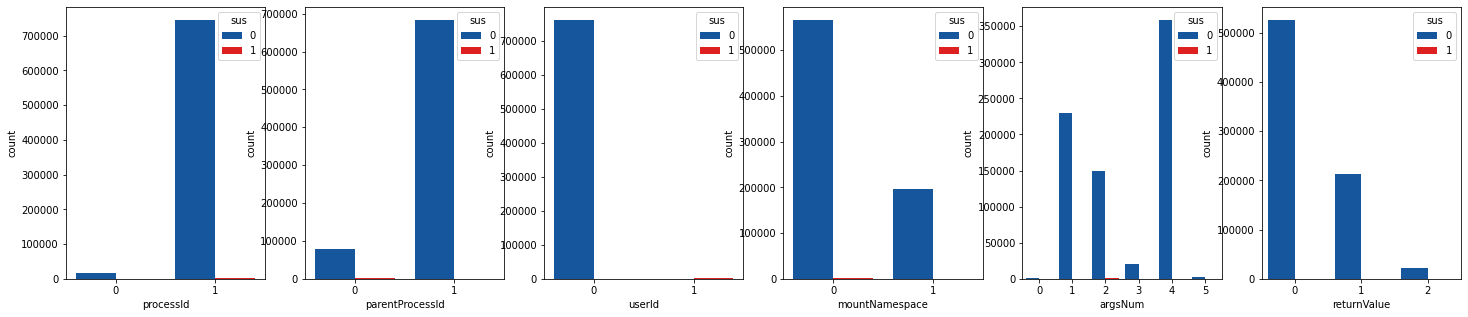

In [26]:
features = ["processId", "parentProcessId", "userId", "mountNamespace", "argsNum", "returnValue"]
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6,figsize = (25,5))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax ,feature in zip(axs, features):
    sns.countplot(x=feature, data=trainingPlot, hue = 'sus', palette=["#0055b3","#FF0000"], ax=ax)


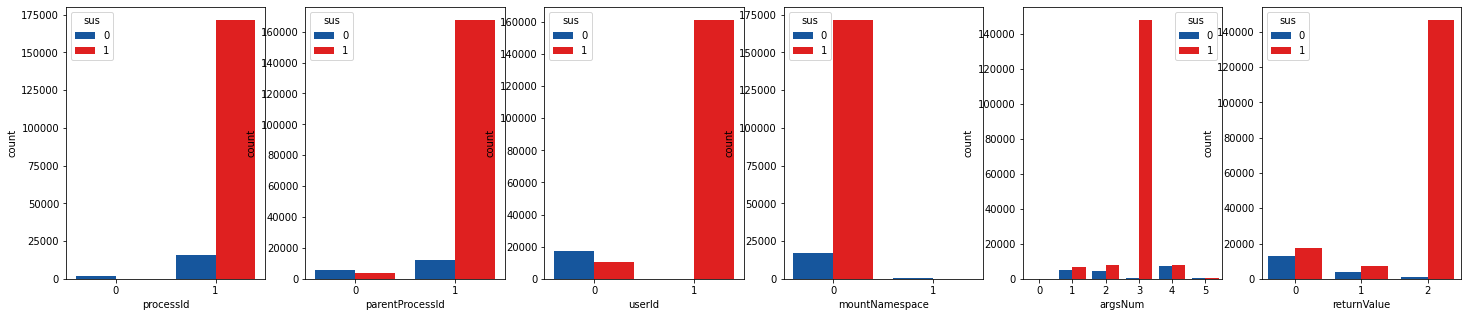

In [27]:
features = ["processId", "parentProcessId", "userId", "mountNamespace", "argsNum", "returnValue"]
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6,figsize = (25,5))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax ,feature in zip(axs, features):
    sns.countplot(x=feature, data=testingPlot, hue = 'sus', palette=["#0055b3","#FF0000"], ax=ax)

